### Section 1 : 

An overview of the types of operations that a Bloom filter supports, and where Bloom filters might be useful.


A Bloom filter is a probabilistic data structure that efficiently checks whether a specific value exists in a particular set. The efficient-accuracy trade-off is a result of the probabilistic nature of Bloom filters; meaning, it is time and space efficient however it has an expected rate of false positive results (which increase with the set's size). 

A simple example will be checking the availability of the desired username in a sign-up process for a website. 

Bloom filter supports two central operations: add and test.

- An addition of an element to a set is due using k hash function. These functions determine k slots in the table to be marked with True; signifying the item's addition. A slot can have a value of either True or False, meaning once it changes to True it will remain static for any other additional relevant to this slot.  For this reason, deletion is impossible; a slot cannot be reverted to False since it holds information regarding several values. An add operation will never fail, giving Bloom filter its unique property of being very space efficient; there is no limit on the number of elements can be stored in a bloom filter.  

- A test for a given element includes checking all the associated slots. This can result in a negative result in case of one or more slots return a False or a probabilistic positive in case all slots return True. The false positive rate is a function of the bloom filter's size (m), the number of independent hash functions used (k), and the number of items inserted into the table (n).  Following this relation:
$$ P = (1- (1 - \frac{1}{m})^{kn})^{k} $$

There are several more operation that can be applied to bloom filters:

- Union of bloom filters using AND operators. The united bloom filter is equal to a hypothetical bloom filter that would have been created by using one table to being with. (since the operator AND is the operator used in the add operation)
- The intersection of a bloom filter using OR operator. The result has a significant downside; it carries the ceiling false positive probability of its constituents; which may be larger than the this of a hypothetical brand new table holding the same values.

Bloom filters have many applications. 
- Distributed caching is one of them. Proxy servers in the same network operating under a single cache such in a case of a local cache miss, proxy requests another proxy in the network. A naive application will be to broadcast the request; this introduces a large load on the network. However, using bloom filters to hold all URLs and exchange bloom filters periodically can increase the process's efficiency. I.E:

1. A proxy has a cache miss
2. It checks its cache summary for a proxy that holds this information and 
3. True positive: the proxy gets the desired address after a single query
4. False positive: the proxy fails to get a cached address from a given proxy and requests it externally (or reaches the actual address)

In this case, bloom filters reduce the network load and increase the speed of retrieving the desired address.


Bloom filter unique properties:
1. set size hash table can represent an arbitrarily large number of elements 
2. There is always a possibility to add another item to the table; it never fails but increases the probability of false positive
3. Deletion is impossible to maintain the zero rate of false negative property ( a single positive bit represents more than one value due to the use of k hash function).

### section 2:

In [1]:
import math
from bitarray import bitarray
import hashlib
import matplotlib.pyplot as plt
import random
import string
import numpy as np

In [2]:


class Bloomfilter(object):
    def __init__(self, expeced_items, desired_fp_prob, set_bitsize = None):
            
            self.expeced_items = expeced_items
            self.desired_fp_prob = desired_fp_prob 
            
            #optimized values 
            self.opt_size = set_bitsize or self.opt_bitsize()
            self.opt_hashfuncs = self.opt_hash()
            
            #actual items count
            self.item_count = 0
            
            # initialize a bitarray of 0 given the number of items 
            self.bit_array = bitarray(self.opt_size)
            self.bit_array.setall(0)
            
    
    
    def opt_bitsize (self):
        '''
        using the formula m = -(frac{n ln p}{(ln 2)^2}) to calculate 
        the optimized bit size (m)
        for a given number of expected items (n) 
        to suit a desireable false positive probability (p) 
        
        '''
        n, p = self.expeced_items, self.desired_fp_prob
        
        return int( - (1.0 * n * math.log(p))/ (math.log(2)**2))
        
        
        
    
    def opt_hash (self) :
        '''
        using the formula frac{m}{n} * ln 2 to calculate 
        the relevant amount of hash function (k)
        to be used to minimize the false positive probability (p)
        for a given bit size (m)
        and expected items (n)

        '''
        
        m, n = self.opt_size, self.expeced_items
        
        return int( (m/n) * math.log(2) )
        

     
    def theorethical_fp (self):
        '''
        calculating the false positive probability using :
        P = (1- (1 - \frac{1}{m})^{kn})^k
        given bitsiez (m)
        current amount of elements in the filter (n)
        the number of used hash function (k)
        '''
        
        n, m, k = self.item_count, self.opt_size, self.opt_hashfuncs
        
        
        return  (1 - (1 - 1.0/m)**(k*n))**k

        
        
     
    def double_hash (self, item):
        '''
        using the following hash function : 
            g_i (x) = ( h_1 (x) +i h_2 (x) +i^2 ) mod m
            
        '''
        
        slots = []
        
        for k in range(self.opt_hashfuncs):
            
                part_a = hashlib.md5(item).hexdigest()
                part_b = hashlib.sha1(item).hexdigest()
            
                slot = (int(part_a,16) + k * int(part_b,16) + k**2 )% self.opt_size
                 
                slots.append(slot)
                
        return slots
                
                
        
    def add (self, item):
     
        # mark relevant slots as True
        slots = self.double_hash(item)
        
        for slot in slots:
          
            self.bit_array[slot] = True
    
    
        # mark that an item was added to the filter
        self.item_count += 1
           
        
    def test (self, item):
        
        slots = self.double_hash(item)
        for slot in slots:
                
            if self.bit_array[slot] == False:
                return False
                
        return True
    
   
def randomword(length):
    return ''.join(random.choice(string.lowercase) for i in range(length))

                

### Section 3: 

This Bloom filter implication uses double hashing following the  (Kirsch & Mitzenmacher, 2008): 
            $$ g_i (x) = ( h_1 (x) +i h_2 (x) +i^2 ) mod m $$
            
such that $h_1$ is MD5 and $h_2$ is SHA1.

https://www.eecs.harvard.edu/~michaelm/postscripts/rsa2008.pdf

Using this form of double hashing proven to be utterly random, hence support the assumption of randomly distributed hash results that underly the probabilistic nature math of Bloom filters.

Both are cryptographic hash algorithms (a function that maps a given data to a set length output which design to be one-way; meaning, infeasible to invert). However, not considered to be cryptographically safe since several successful brute-force attacks a few years ago.

MD5 :
Data preparation includes dividing the input to blocks (512 bits each) and each block into 16 chunks (32 bits each).
Every four chunks of each block processed independently, and its result added to the result of the previous block.
The process goes as follows:
Four auxiliary functions take each of the four chunks as inputs and apply some combination of logical operations (using OR, XOR, AND, and NOT), the output is bring rotated (differently with every round) to get the round result.

The final digest is the cumulative sum of the results in size of a 128-bit value.

SHA1:
The SHA1 algorithm is similar to the MD5 algorithm. SHA1 has five auxiliary function that operates on five chunks at a time resulting in a digest of 160 bit. SHA1 is stronger yet slower than MD5.



### Section 4:

The intuitive explanation for the Bloom filter provided alongside the mathematical one for each statement. To use the math, I firstly simplified it into simple steps. A math-free explanation is presented in each statement.

False positive rate and cupcakes. 

A bloom filter is like a cupcake tray. Assuming a given number of ingredients, one tries to follow random recipes to create various cakes. The recipe does not include instructions for each cake yet it tells you in which cup to mix which ingredients. Let's say that after forming the randoms mixtures, one bakes the cupcakes and gives them to a friend that then tries to recall which ingredients were used. For a given tray, the more ingredients you use, the harder it gets to distinguish which ingredients are used in which cupcake and the chances one will be confused increased. This is false positive rate; since each slot in the bloom filter hols information on a random (hopefully uniformly distributed) amount of items, the more items there is, the less representative the filter is.  

(An exception, this example ignores the promise of a zero false negative rate in Bloom filters) 



Mathematical notations :
The Bloom filter is a probabilistic data structure since its accuracy is deterministic and can be calculated using statistical tools. The next paragraph is a short explanation of this property of the Bloom filter. Assuming that the used hash function is perfectly randomized; the probability of a single slot to remain False after insertion of n items is:

$$ p_{False_n}=(1-\frac{1}{m})^{kn}$$

Cosidering to use of k independent hash function (where m is the size of the filter). Forming the inverse probability as 

$$ p_{True_n} = 1-(1-\frac{1}{m})^{kn}$$ 

Represents the probability of single slot to be positive after n insertion using k hash functions. The false positive probability is the probability of k slots (calculated by k hash functions) to be positive denotated by 

$$p_{fp} =(1-(1-\frac{1}{m})^{kn})^{k} $$ 

Using the  approximation 

$$p_{fp}' \approx (1-e^{\frac{-kn}{m}})^{k} $$

we can find the optimum to the hash function to be 

$$ k_{optimum} = \frac{m}{n} ln{2}$$ 

Using the optimized value for k in the original false positive probability function, we find the optimal value for the filter size (m) : 
$$m =  -\frac{n ln p}{(ln 2)^2}$$




(1) Memory:
Recalling the cupcake example, comparing different trays (with varying amount of cups) can help us modify the tasting confusion. For the same amount of ingredients, more cups means fewer ingredients in each cup (on average), so hopefully, each ingredient will be more prevalent. Equal to the filter, bigger memory size helps reduce the false positive rate for a given set of expected items. However, since the tray size is set before starting to mix, the number of ingredients being added will not change it (even if some cups will remain empty); the memory size is not a function of the items stored.

Mathemtically, 

bitsize = $O(-\ln{p})$ and  $O(n)$ but has no ralation to inserted items

Once initialized, the size of the Bloom filter is static. The optimization of the memory needed is dependent on the expected items to be stored (n) as well as the desired false positive rate (p). As shown by the following formula ;

$$ memory = \frac{ -n\ln{p}}{\ln{2}^2} $$


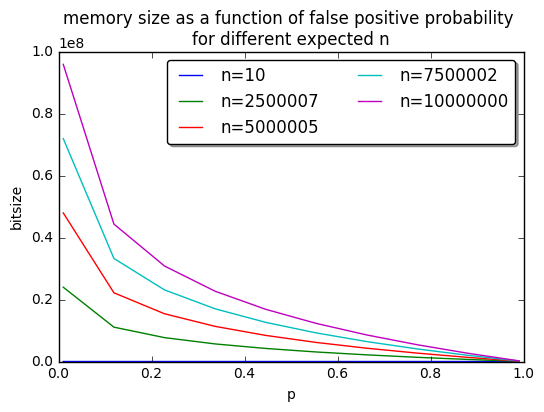

In [68]:
# memory size as a function of p:
data = []

for n in np.linspace(10, 10**7, 5,dtype=int):
    data_per_p = []
    
    for p in np.linspace(0.01, .99, 10,dtype=float):
        memory_bf = Bloomfilter(n,p)
        
        data_per_p.append(memory_bf.opt_bitsize())
    
    plt.plot (np.linspace(0.01, .99, 10,dtype=float), data_per_p, label='n={}'.format(n))
#     data.append(data_per_p)    


plt.xlabel('p')
plt.ylabel('bitsize')
plt.title('Memory size as a function of false positive probability \nfor different expected n')    
plt.legend(loc='right center', fancybox=True, shadow=True, ncol=2)

plt.show()        



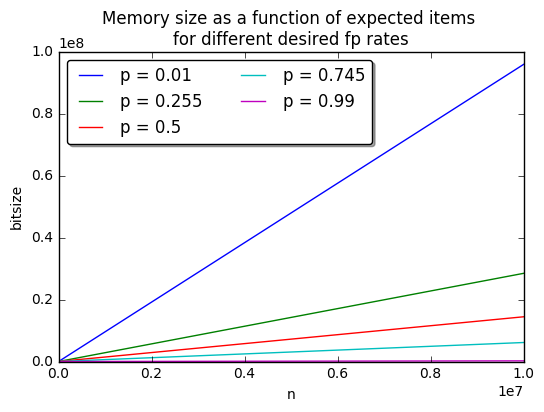

In [73]:
# memory size as a function of n:

data = []

for p in np.linspace(0.01, .99, 5,dtype=float):

    data_per_n = []
    
    for n in np.linspace(10, 10**7, 30,dtype=int):
        memory_bf = Bloomfilter(n,p)
        
        data_per_n.append(memory_bf.opt_bitsize())
    
    plt.plot (np.linspace(10, 10**7, 30,dtype=int), data_per_n, label='p = {}'.format(p))
    
    data.append(data_per_p)    


plt.xlabel('n')
plt.ylabel('bitsize')
plt.title('Memory size as a function of expected items \nfor different desired fp rates')    
plt.legend(loc='right center', fancybox=True, shadow=True, ncol=2)

plt.show()        




(2) Access time

A less tasety analogy, 




Mathematically, 
The runtime to add/check an item in a filer is exclusively dependent on the number of the hash function (k) used; equivalently, the amount of slots to change/look into. For a given number of expected items with a set bitsize, an increasing acceptable false positive rate will require less hash functions. Similarly, for a set bitsize, to accomodate more items and maintain the false positive rate set, one needs less hash functions (less slots to modify means more unique value in each slot)

Time: $O(k)$ and $k = \frac{m}{n} \ln{2}$ can also be written as $k = -\log_2 p $
Using asymptotic notations, the complexity is $O(-lg p)$ and $O(1/n)$ but has no realtion to inserted items. 


- access time as a function of the false positive rate
    k as a function of p
        
        
- access time as a function of the number of items stored
    time as a function of n



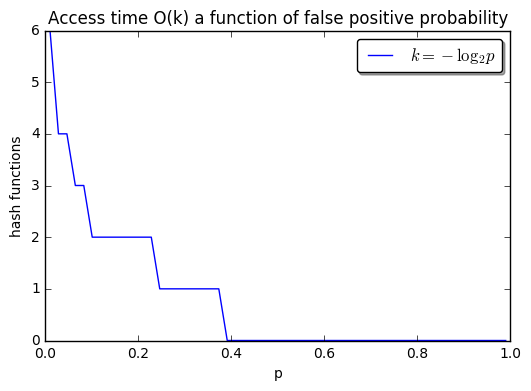

In [36]:
# k as a function of p:
data_per_p = []

n=10000

for p in np.linspace(0.01, .99, 55,dtype=float):
    memory_bf = Bloomfilter(n,p)
        
    data_per_p.append(memory_bf.opt_hash())
    
plt.plot(np.linspace(0.01, .99, 55,dtype=float), data_per_p, label=r'$k= -\log_2 p$')


plt.xlabel('p')
plt.ylabel('hash functions')
plt.title('Access time O(k) a function of false positive probability')    
plt.legend(loc='right center', fancybox=True, shadow=True, ncol=2)

plt.show()        






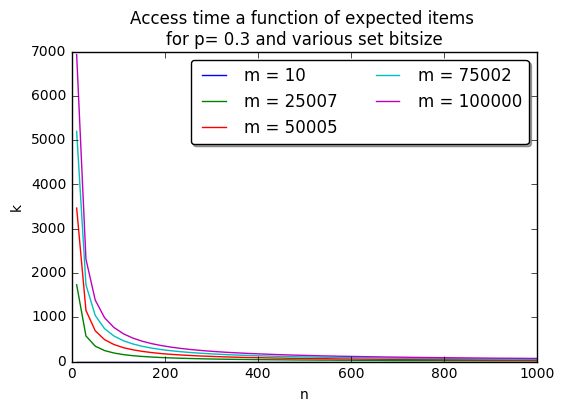

In [9]:
# k as a function of n:

# $k = \frac{m}{n} \ln{2}$

p = 0.3

for m in np.linspace(10, 10**5, 5, dtype=int):

    data_per_n = []
    
    for n in np.linspace(10, 1000, 50, dtype=int):
        
        memory_bf = Bloomfilter(n, p, m)
        
        data_per_n.append(memory_bf.opt_hash())

    plt.plot (np.linspace(10, 1000, 50, dtype=int), data_per_n, label='m = {}'.format(m))
 


plt.xlabel('n')
plt.ylabel('k')
plt.title('Access time a function of expected items \nfor p= {} and various set bitsize'.format (p))    
plt.legend( fancybox=True, shadow=True, ncol=2)

plt.show()        





### section 5:  False positive rates


In [54]:
def add_and_test (n,p):

    real_pf = []
    theo_pf = []

    bf = Bloomfilter(n,p)


    # words to be added
    added_words = list(set([randomword(5) for i in range (n)]))
 
    # word not added
    absent_words = list(set([randomword(6) for i in range (500)]))
    absent_words = set(absent_words).difference(added_words)

    random.shuffle(added_words)

    for word in added_words:
    
        bf.add(word)
        theo_pf.append(bf.theorethical_fp())
    
        real_pf_count = 0
    
        for not_word in absent_words:
            if (bf.test(not_word)): 
                real_pf_count +=1
    
        real_pf.append(real_pf_count/float(len(absent_words))) 

    print bf.opt_hashfuncs, bf.opt_size
    
    return {"real":real_pf, "theo": theo_pf}



2 47925


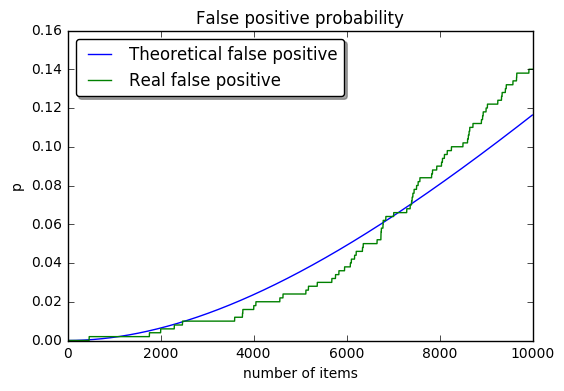

In [55]:
results = add_and_test (10000,0.1)

theo_pf = results['theo']
real_pf = results['real']


plt.plot ([i for i in range(len(theo_pf))], theo_pf, label = 'Theoretical false positive')
plt.plot ([i for i in range(len(real_pf))], real_pf, label = 'Real false positive')

plt.xlabel('number of items')
plt.ylabel('p')
plt.title('False positive probability')
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=1)


plt.show()

331
1024 0.0009765625
332
1024 0.01611328125
333
1024 0.03125
334
33280 0.0009765625
335
33280 0.01611328125
336
33280 0.03125
337
65536 0.0009765625
338
65536 0.01611328125
339
65536 0.03125


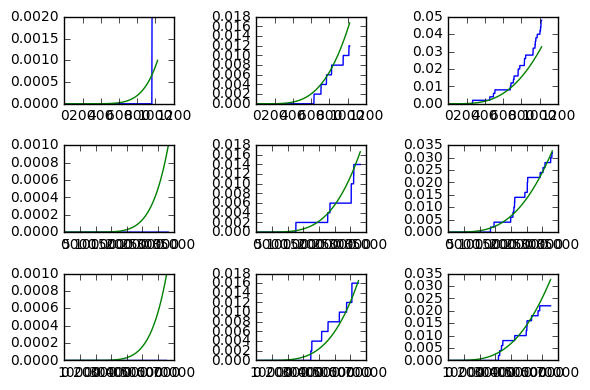

In [52]:
results = []
pos = 1

plt.xlabel('number of items')
plt.ylabel('p')
plt.title('False positive probability for various parameters')

for n_index,n in  enumerate(np.linspace(2**10, 2**16, 3, dtype=int)): #range the expected items
    for p_index,p in  enumerate(np.linspace(2**-10, 2**-5, 3)): #range the false positive probability
        fog = add_and_test (n,p)
        results.append(fog)
        
        theo_pf = fog['theo']
        real_pf = fog['real']
        
        tmp = 330 + pos
        pos +=1
        
        plt.subplot(tmp)
        
        plt.plot ([i for i in range(len(theo_pf))], theo_pf, label = 'Theoretical false positive')
        plt.plot ([i for i in range(len(real_pf))], real_pf, label = 'Real false positive')

        print tmp
        print n,p

plt.tight_layout()
plt.show()

In [31]:
'''
A counting Bloom filter has the additional operation of deleting items from the filter. 
However, it comes with a trade-off; either the space efficiency is jeopardizes 
(since a slot that in a normal BF holds one bit, can hold very long numbers)
or there is a cap on the amount of items possible to enter (to keep the space bounded).

In this implemetation I chose to cap the number of items; the cap hold the count of each 
slot to a max of 8 bits. 
'''

class C_Bloomfilter(object):
    def __init__(self, expeced_items, desired_fp_prob, set_bitsize = None):
            
            self.expeced_items = expeced_items
            self.desired_fp_prob = desired_fp_prob 
            
            #optimized values 
            self.opt_size = set_bitsize or self.opt_bitsize()
            self.opt_hashfuncs = self.opt_hash()
            
            #actual items count
            self.item_count = 0
            
            # initialize a bitarray of 0 given the number of items 
            self.bit_array = bitarray(self.opt_size)
            self.bit_array.setall(0)
            
            # slot limitation 
            self.limit_per_slot = 256
    
    
    def opt_bitsize (self):
        '''
        using the formula m = -(frac{n ln p}{(ln 2)^2}) to calculate 
        the optimized bit size (m)
        for a given number of expected items (n) 
        to suit a desireable false positive probability (p) 
        
        '''
        n, p = self.expeced_items, self.desired_fp_prob
        
        return int( - (1.0 * n * math.log(p))/ (math.log(2)**2))
        
        
        
    
    def opt_hash (self) :
        '''
        using the formula frac{m}{n} * ln 2 to calculate 
        the relevant amount of hash function (k)
        to be used to minimize the false positive probability (p)
        for a given bit size (m)
        and expected items (n)

        '''
        
        m, n = self.opt_size, self.expeced_items
        
        return int( (m/n) * math.log(2) )
        

     
    def theorethical_fp (self):
        '''
        calculating the false positive probability using :
        P = (1- (1 - \frac{1}{m})^{kn})^k
        given bitsiez (m)
        current amount of elements in the filter (n)
        the number of used hash function (k)
        '''
        
        n, m, k = self.item_count, self.opt_size, self.opt_hashfuncs
        
        
        return  (1 - (1 - 1.0/m)**(k*n))**k

        
        
     
    def double_hash (self, item):
        '''
        using the following hash function : 
            g_i (x) = ( h_1 (x) +i h_2 (x) +i^2 ) mod m
            
        '''
        
        slots = []
        
        for k in range(self.opt_hashfuncs):
            
                part_a = hashlib.md5(item).hexdigest()
                part_b = hashlib.sha1(item).hexdigest()
            
                slot = (int(part_a,16) + k * int(part_b,16) + k**2 )% self.opt_size
                 
                slots.append(slot)
                
        return slots
                
                
        
    def add (self, item):
     
        # mark relevant slots as True
        slots = self.double_hash(item)
        
        for slot in slots:
            
            if self.bit_array[slot] < self.limit_per_slot:
          
                # add to the count of the relevant slots
                self.bit_array[slot] += 1
            
            else:
                raise NameError('too many items have been added')
                
    
        # mark that an item was added to the filter
        self.item_count += 1
           
        
    def test (self, item):
        
        slots = self.double_hash(item)
        for slot in slots:
                
            if not self.bit_array[slot]:
                return False
                
        return True

    
    def remove (self, item):
        # checks the item are in the array
        if self.test(item):
            
            slots = self.double_hash(item)
            
            #reduces the count of teh releavnt slots
            for slot in slots:

                self.bit_array[slot] -= 1


            # reduce the general count of items
            self.item_count -= 1
            
        else:
            raise NameError('item was not found')
            

    